In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from copy import deepcopy
from importlib import import_module

import numpy as np
import torch
from omegaconf import OmegaConf
from torch import nn

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.rc("font", **{"size": 20})
plt.rc("lines", linewidth=4.0)
mpl.rcParams['lines.markersize'] = 20
mpl.rcParams['lines.markeredgewidth'] = 2

fig_size = 6

In [3]:
cfg = OmegaConf.create(
    {
        "num_pathways": 7,  # this is M
        # for the ith layer, hidden_dims[i] is the input dim and
        # hidden_dims[i+1] is the output dim
        "hidden_dims": [64, 64, 64, 64],
        "input_dim": 4,
        "output_dim": 7,
        "case": "1",  # from the google doc
        "init_scale": .2,
        "should_init_decoupled": False,
        "should_use_bias": False,
        "num_epochs": 500,
        "loss": {
            "cls": "torch.nn.MSELoss",
            "reduction": "none",
        },
        "optimizer": {
            "cls": "torch.optim.SGD",
            "lr": .02,  # .005,#.01,
            "momentum": 0,
            "dampening": 0,
            "weight_decay": 0,
            "nesterov": False,
        },
        "gate": {
            # other supported modes are: mod, k_plus_mod, k_plus_minus_mod
            # where k is an integer
            "mode": "4_plus_minus_mod",
            "num_classes": 4
        },
        "num_trained_pathways": 4
    }
)
# cfg is a dictionary with "." access eg cfg["abc"] == cfg.abc

device = torch.device("cpu")

In [4]:
######
X = torch.eye(n=cfg.input_dim).to(device)
Y = (
    torch.cat(
        [
            6.*torch.ones((1, cfg.input_dim)),
            torch.tensor([4, 4, 0, 0]).unsqueeze(0),
            torch.tensor([0, 0, 4,4]).unsqueeze(0),
            3*torch.eye(n=cfg.input_dim),
        ]
    )
    .to(device)
    .t()
)

print(f"X: {X}")
print(f"Y: {Y}")
print("Created Tensors")

X: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])
Y: tensor([[6., 4., 0., 3., 0., 0., 0.],
        [6., 4., 0., 0., 3., 0., 0.],
        [6., 0., 4., 0., 0., 3., 0.],
        [6., 0., 4., 0., 0., 0., 3.]])
Created Tensors


In [5]:
class GatedDLN(nn.Module):
    def __init__(
            self,
            num_tasks,
            input_dim,
            hidden_dims,
            output_dim,
            case,
            should_use_bias):
        self.tasks = OmegaConf.create({"shape": [num_tasks, num_tasks]})
        super().__init__()
        self.input = nn.ModuleList(
            [
                nn.Linear(input_dim, hidden_dims[0], bias=should_use_bias)
                for _ in range(num_tasks)
            ]
        )
        self.hidden = nn.Linear(
            hidden_dims[0],
            hidden_dims[1],
            bias=should_use_bias)
        self.out = nn.ModuleList(
            [
                nn.Linear(hidden_dims[-1], output_dim, bias=should_use_bias)
                for _ in range(num_tasks)
            ]
        )
        self.gate = self.make_gate()
        self.loss_fn = make_cls(cfg=deepcopy(cfg.loss))

    def make_gate(self):
        # feel free to define a gate yourself
        mode = cfg.gate.mode
        if mode == "fully_connected":
            gate = torch.ones(
                *self.tasks.shape,
                device="cpu",
                dtype=torch.float32)
            return gate.unsqueeze(2)

        input_output_map = self._get_input_output_map(mode=mode)
        gate = torch.zeros(
            *self.tasks.shape,
            device="cpu",
            dtype=torch.float32)
        for current_input, current_output in input_output_map:
            gate[current_input][current_output] = 1.0
        if mode.endswith("permute"):
            gate = gate[:, torch.randperm(gate.shape[1])]
        # print(gate)
        #print(gate.shape, gate.sum().item())
        return gate.unsqueeze(2)

    def _get_input_output_map(self, mode: str):
        input_output_map = []
        if "_plus_mod" in mode:
            num_cols = int(mode.split("_plus_mod")[0])
            num_rows = self.tasks.shape[0]
            for i in range(num_rows):
                for j in range(num_cols):
                    input_output_map.append((i, (i + j) % num_rows))
        elif "_plus_minus_mod" in mode:
            num_cols = int(mode.split("_plus_minus_mod")[0])
            num_rows = self.tasks.shape[0]
            for i in range(num_rows):
                for j in range(-1 * ((num_cols - 1) // 2),
                               (num_cols // 2) + 1):
                    input_output_map.append((i, (i + j + num_rows) % num_rows))
        elif mode == "mod":
            for i in range(min(cfg.gate.num_classes, self.tasks.shape[0])):
                input_output_map.append((i, i))
        else:
            raise NotImplementedError(f"mode = {mode} is not supported.")
        #print(f"input_output_map: {input_output_map}")
        return input_output_map

    def to(self, device, *args, **kwargs):
        self.gate = self.gate.to(device)
        return super().to(device, *args, **kwargs)

    def forward(self, x, y):
        features = [
            encoder(x) for encoder in model.input
        ]
        hidden = [model.hidden(f) for f in features]
        #outputs = [[d(h) for d in model.out] for h in hidden]

        M = cfg.num_pathways
        loss_tensor = torch.zeros(M, M)
        for i, a in enumerate(hidden):
            for j, b in enumerate(model.out):
                if model.gate.squeeze()[i, j] == 1:
                    loss_tensor[i, j] = model.loss_fn(b(a), y).mean()

        loss = loss_tensor.sum()
        return loss


def run_one_input_per_module(x_list, module_list):
    return torch.cat([module(x).unsqueeze(0)
                      for x, module in zip(x_list, module_list)], dim=0)


def run_one_domain_per_module(x_list, module_list):
    return [module(x_list) for module in module_list]


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.orthogonal_(m.weight, gain=cfg.init_scale)
        


def make_cls(cfg, kwargs=None):
    module, cls = cfg.pop("cls").rsplit(".", 1)
    if kwargs is None:
        kwargs = {}
    return getattr(import_module(module), cls)(**cfg, **kwargs)


device = torch.device("cpu")

Nreps = 10

losses = []
input_svs = []
hidden_svs = []
out_svs = []

for rep in range(Nreps):
    model = GatedDLN(
        num_tasks=cfg.num_pathways,
        input_dim=cfg.input_dim,
        hidden_dims=cfg.hidden_dims,
        output_dim=cfg.output_dim,
        case=cfg.case,
        should_use_bias=cfg.should_use_bias,
    ).to(device)


    if not cfg.should_init_decoupled:
        model.apply(init_weights)

    else:
    # Fully balanced, decoupled init

        with torch.no_grad():

            u,s,v = np.linalg.svd(Y.T)
            Ninp = cfg.input_dim
            Nh = cfg.hidden_dims[0]
            Nout = cfg.output_dim
            r2,_,r1 = np.linalg.svd(model.hidden.weight)
            for m in model.input:
                m.weight = torch.nn.Parameter(torch.tensor((r1.T)[:,0:Ninp] @ ( cfg.init_scale*np.eye(Ninp) ) @ v, dtype=torch.float))

            #r3,_,r4 = np.linalg.svd(np.random.normal(0,1,model.hidden.weight.shape))
            model.hidden.weight = torch.nn.Parameter(torch.tensor(r2 @ ( cfg.init_scale*np.eye(Nh) ) @ r1, dtype=torch.float))#torch.nn.Parameter(torch.tensor(r2 @ ( cfg.init_scale*np.eye(Nh) ) @ r1, dtype=torch.float))

            for m in model.out:
                m.weight = torch.nn.Parameter(torch.tensor(u @ ( cfg.init_scale*np.eye(Nout) ) @ (r2.T)[0:Nout,:], dtype=torch.float))


    loss_fn = make_cls(cfg=deepcopy(cfg.loss))

    optimizer = make_cls(
        cfg=deepcopy(
            cfg.optimizer), kwargs={
                "params": model.parameters()})

    loss_list = []

    input_sv_list = []
    hidden_sv_list = []
    out_sv_list = []


    for epoch in range(cfg.num_epochs):
        optimizer.zero_grad()
        loss = model(X, Y)
        loss_list.append(loss.detach().cpu())

        if epoch%2==0:
            ui,si,vi = np.linalg.svd(model.input[0].weight.detach().numpy())
            input_sv_list.append(si)

            uh,sh,vh = np.linalg.svd(model.hidden.weight.detach().numpy())
            hidden_sv_list.append(sh[0:10])

            uo,so,vo = np.linalg.svd(model.out[0].weight.detach().numpy())
            out_sv_list.append(so[0:7])


        loss.backward()
        optimizer.step()


    plt.plot(loss_list, label="loss")
    plt.xlabel("number of updates")
    plt.ylabel("loss")
    plt.legend()

    losses.append(np.vstack(loss_list))
    input_svs.append(np.vstack(input_sv_list))
    hidden_svs.append(np.vstack(hidden_sv_list))
    out_svs.append(np.vstack(out_sv_list))


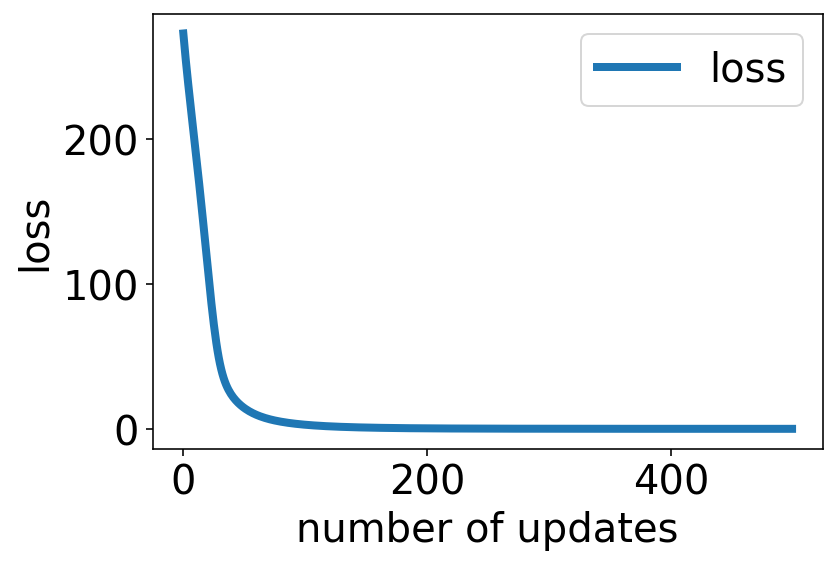

In [ ]:
cfg.optimizer.lr = .005
cfg.init_scale = 2

Nreps_ntk = 1

losses_ntk = []
input_svs_ntk = []
hidden_svs_ntk = []
out_svs_ntk = []

for rep in range(Nreps_ntk):
    model = GatedDLN(
        num_tasks=cfg.num_pathways,
        input_dim=cfg.input_dim,
        hidden_dims=cfg.hidden_dims,
        output_dim=cfg.output_dim,
        case=cfg.case,
        should_use_bias=cfg.should_use_bias,
    ).to(device)


    if not cfg.should_init_decoupled:
        model.apply(init_weights)

    else:
    # Fully balanced, ntkled init

        with torch.no_grad():

            u,s,v = np.linalg.svd(Y.T)
            Ninp = cfg.input_dim
            Nh = cfg.hidden_dims[0]
            Nout = cfg.output_dim
            r2,_,r1 = np.linalg.svd(model.hidden.weight)
            for m in model.input:
                m.weight = torch.nn.Parameter(torch.tensor((r1.T)[:,0:Ninp] @ ( cfg.init_scale*np.eye(Ninp) ) @ v, dtype=torch.float))

            #r3,_,r4 = np.linalg.svd(np.random.normal(0,1,model.hidden.weight.shape))
            model.hidden.weight = torch.nn.Parameter(torch.tensor(r2 @ ( cfg.init_scale*np.eye(Nh) ) @ r1, dtype=torch.float))#torch.nn.Parameter(torch.tensor(r2 @ ( cfg.init_scale*np.eye(Nh) ) @ r1, dtype=torch.float))

            for m in model.out:
                m.weight = torch.nn.Parameter(torch.tensor(u @ ( cfg.init_scale*np.eye(Nout) ) @ (r2.T)[0:Nout,:], dtype=torch.float))


    loss_fn = make_cls(cfg=deepcopy(cfg.loss))

    optimizer = make_cls(
        cfg=deepcopy(
            cfg.optimizer), kwargs={
                "params": model.parameters()})

    loss_list = []

    input_sv_list = []
    hidden_sv_list = []
    out_sv_list = []


    for epoch in range(cfg.num_epochs):
        optimizer.zero_grad()
        loss = model(X, Y)
        loss_list.append(loss.detach().cpu())

        if epoch%2==0:
            ui,si,vi = np.linalg.svd(model.input[0].weight.detach().numpy())
            input_sv_list.append(si)

            uh,sh,vh = np.linalg.svd(model.hidden.weight.detach().numpy())
            hidden_sv_list.append(sh[0:10])

            uo,so,vo = np.linalg.svd(model.out[0].weight.detach().numpy())
            out_sv_list.append(so[0:7])


        loss.backward()
        optimizer.step()


    plt.plot(loss_list, label="loss")
    plt.xlabel("number of updates")
    plt.ylabel("loss")
    plt.legend()

    losses_ntk.append(np.vstack(loss_list))
    input_svs_ntk.append(np.vstack(input_sv_list))
    hidden_svs_ntk.append(np.vstack(hidden_sv_list))
    out_svs_ntk.append(np.vstack(out_sv_list))

In [ ]:
cfg.num_trained_pathways

4

In [ ]:
# Theory ODE

u,s,v = np.linalg.svd(np.dot(Y.T,X))
# Code currently assumes input corrs are white

K = cfg.num_trained_pathways
M =  cfg.num_pathways

b0 = cfg.init_scale/2.5
dt = cfg.optimizer.lr*3.5

Nsv = s.shape[0]

num_epochs = cfg.num_epochs
b1 = b0*np.ones((num_epochs,Nsv))
b2 = b0*np.ones((num_epochs,Nsv))
b3 = b0*np.ones((num_epochs,Nsv))

for epoch in range(num_epochs-1):
    
    shat = b3[epoch,:]*b2[epoch,:]*b1[epoch,:]
    b1[epoch+1,:] = b1[epoch,:] + K/M**2*b3[epoch,:]*b2[epoch,:]*(s - shat)*dt
    b2[epoch+1,:] = b2[epoch,:] + K/M*b3[epoch,:]*b1[epoch,:]*(s - shat)*dt
    b3[epoch+1,:] = b3[epoch,:] + K/M**2*b2[epoch,:]*b1[epoch,:]*(s - shat)*dt
    


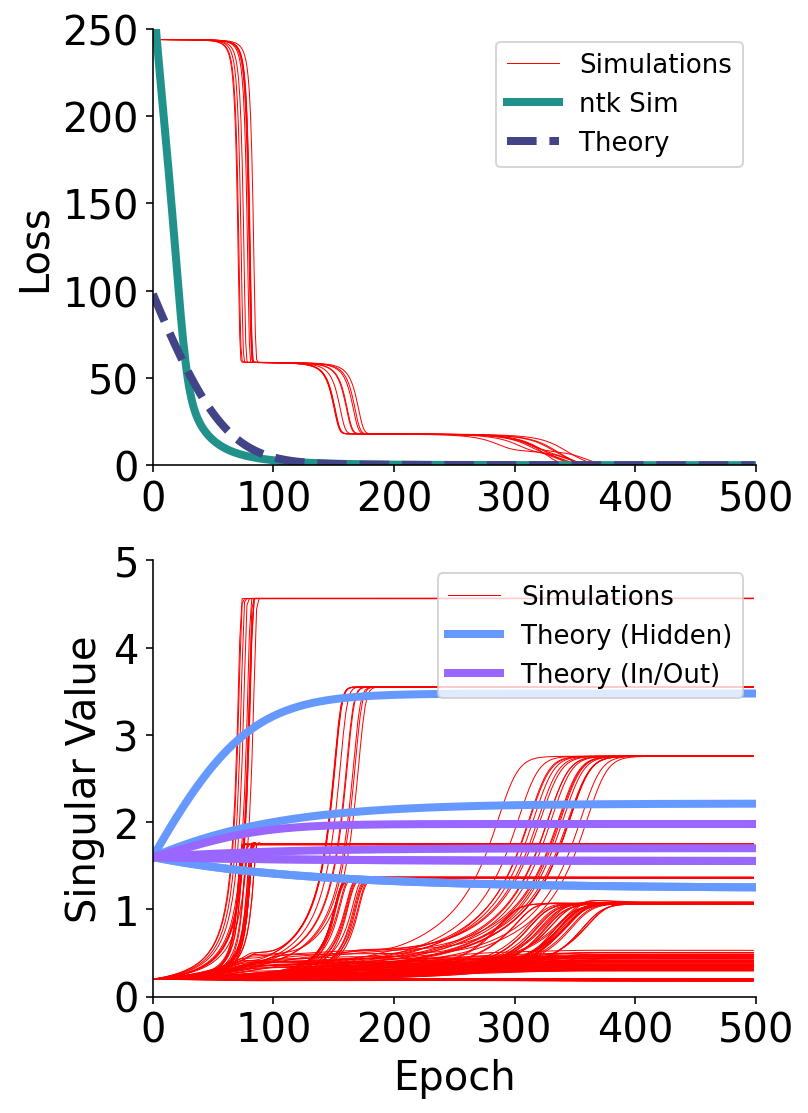

In [ ]:
# Save figure
fig = plt.figure(figsize=(6,8))

ax1=plt.subplot(211)
# Simulations from small random weights
for rep in range(Nreps-1):
    plt.plot(losses[rep], color='r', linewidth=.5)
plt.plot(losses[-1], color='r', linewidth=.5, label='Simulations')

# Simulations from balanced ntk init
plt.plot(losses_ntk[0], color=plt.cm.viridis(.5), linewidth=4, label='ntk Sim')

# Reduction
plt.plot(K/4*np.sum((s - b3*b2*b1)**2,axis=1),color=plt.cm.viridis(.2),linestyle='--', label='Theory')

#plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(fontsize=13)
plt.xlim((0,500))
plt.ylim((0,250))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

#plt.tight_layout()
#plt.savefig('routing_network_loss.pdf')

ax2=plt.subplot(212)
ep = np.arange(0,cfg.num_epochs,2)

#fig = plt.figure(figsize=(10, 4))

for rep in range(Nreps-1):
    plt.plot(ep,input_svs[rep], color='r', linewidth=.5)
    plt.plot(ep,hidden_svs[rep], color='r', linewidth=.5)
    plt.plot(ep,out_svs[rep], color='r', linewidth=.5)
plt.plot(ep,input_svs[-1][:,0], color='r', linewidth=.5,label='Simulations')
plt.plot(ep,input_svs[-1][:,1:], color='r', linewidth=.5)
plt.plot(ep,hidden_svs[-1], color='r', linewidth=.5)
plt.plot(ep,out_svs[-1], color='r', linewidth=.5)

#plt.plot(b1, color=plt.cm.cool(.2), label='Input')
plt.plot(b2[:,0], color=plt.cm.cool(.4), label='Theory (Hidden)')
plt.plot(b2[:,1:], color=plt.cm.cool(.4))
plt.plot(b3[:,0], color=plt.cm.cool(.6), label='Theory (In/Out)')
plt.plot(b3[:,1:], color=plt.cm.cool(.6))
plt.legend(loc='upper right',fontsize=13)#loc=(1.1,.3))
plt.xlabel("Epoch")
plt.ylabel("Singular Value")
plt.ylim((0,5))
plt.xlim((0,500))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
#plt.xlim((100,500))

plt.tight_layout()
#plt.show()

plt.savefig('ntk_dynamics.pdf')

Percentage trained: 0.5714285969734192
7


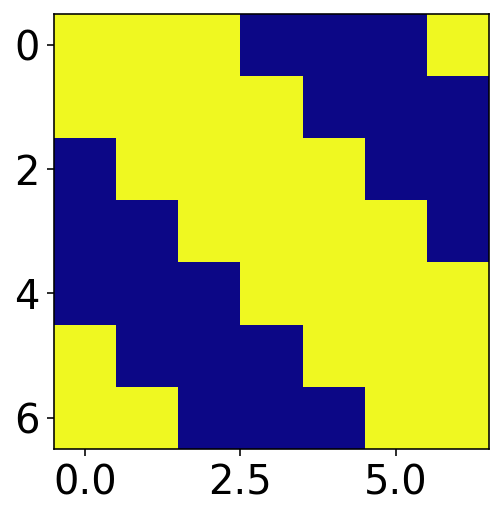

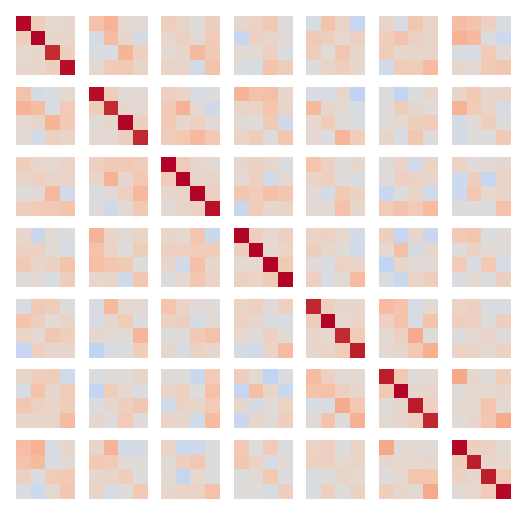

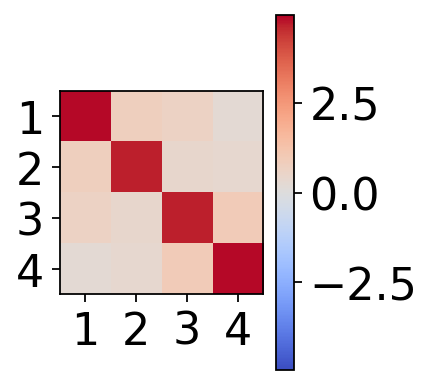

In [ ]:
#
plt.imshow(model.gate, cmap=plt.cm.plasma)
plt.savefig('num_trained_panel.pdf')
print(f"Percentage trained: {model.gate.mean()}")
# Compute hidden representation correlations within and across modalities


M = cfg.num_pathways
print(M)
plt.figure(figsize=(4, 4), dpi=80)

# Figure out scale
outA = model.input[0](X).detach().numpy()
rsa = np.dot(outA, outA.T)
c_limit = np.max(np.abs(rsa))

for i in range(M):
    i
    outA = model.input[i](X)
    #outA = model.hidden(outA)
    outA = outA.detach().numpy()

    for j in range(M):
        outB = model.input[j](X)
        #outB = model.hidden(outB)
        outB = outB.detach().numpy()

        plt.subplot(M, M, i*M+j+1)
        plt.imshow(np.dot(outA, outB.T), cmap=plt.cm.coolwarm)
        plt.clim(-c_limit,c_limit)
        plt.axis('off')

plt.savefig('rsa_ntk_panel.pdf')

plt.figure(figsize=(3, 3), dpi=80)
plt.imshow(np.dot(outA, outB.T), cmap=plt.cm.coolwarm)
#plt.clim(-1,1)
label_list = ['1', '2', '3', '4']

plt.gca().set_xticks([0,1,2,3])
plt.gca().set_xticklabels([i+1 for i in range(4)])
plt.gca().set_yticks([0,1,2,3])
plt.gca().set_yticklabels([i+1 for i in range(4)])
plt.clim(-c_limit,c_limit)
plt.colorbar()
plt.tight_layout()
plt.savefig('rsa_ntk_colorbar.pdf')

In [ ]:
np.dot(outA, outB.T)

array([[12.840709  ,  0.53846395, -0.24294436,  0.68365   ],
       [ 0.53846395, 14.2489605 ,  0.69289255,  0.32738975],
       [-0.24294436,  0.69289255, 14.855614  ,  0.7889399 ],
       [ 0.68365   ,  0.32738975,  0.7889399 , 13.394976  ]],
      dtype=float32)

7


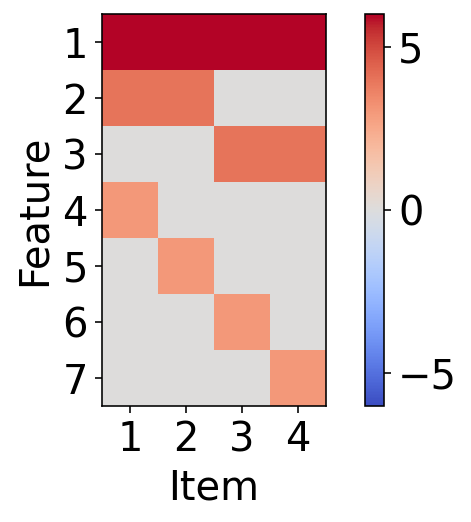

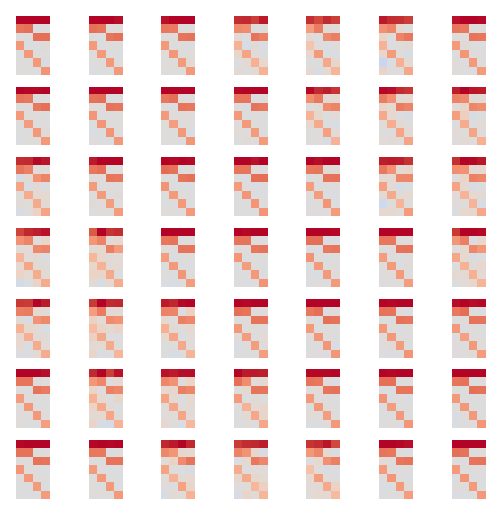

In [ ]:
plt.imshow(Y.T, cmap=plt.cm.coolwarm)
plt.clim((-6,6))
plt.colorbar(ticks=[-5, 0, 5])

plt.gca().set_xticks([0,1,2,3])
plt.gca().set_xticklabels([i+1 for i in range(4)])
plt.gca().set_yticks(np.linspace(0,6,7))
plt.gca().set_yticklabels([r+1 for r in range(7)])
plt.xlabel('Item')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('routing_dataset_ntk.pdf')

M = cfg.num_pathways
print(M)
plt.figure(figsize=(4, 4), dpi=80)
for i in range(M):
    outA = model.input[i](X)
    h = model.hidden(outA)

    for j in range(M):
        o = model.out[j](h)

        plt.subplot(M, M, i*M+j+1)
        plt.imshow(o.detach().numpy().T,cmap=plt.cm.coolwarm)
        plt.clim((-6, 6))
        plt.axis('off')

plt.savefig('routing_output_ntk.pdf')
#plt.tight_layout()

In [ ]:
np.linalg.norm(Y-o.detach().numpy(),'fro')

0.0009329691

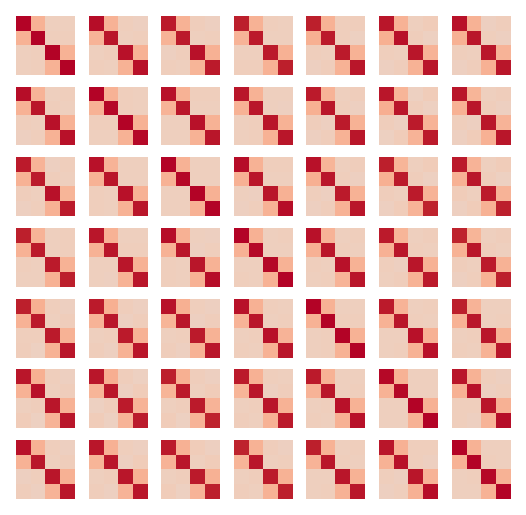

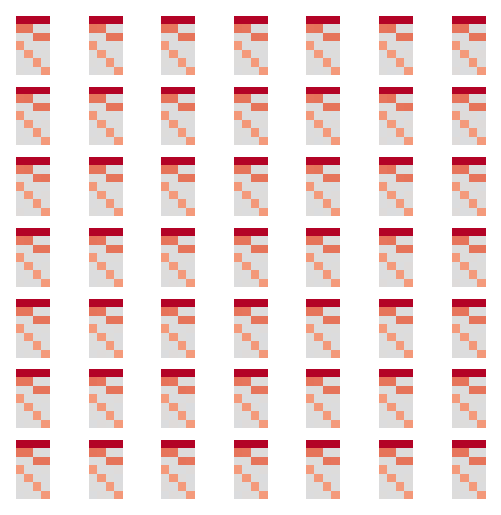

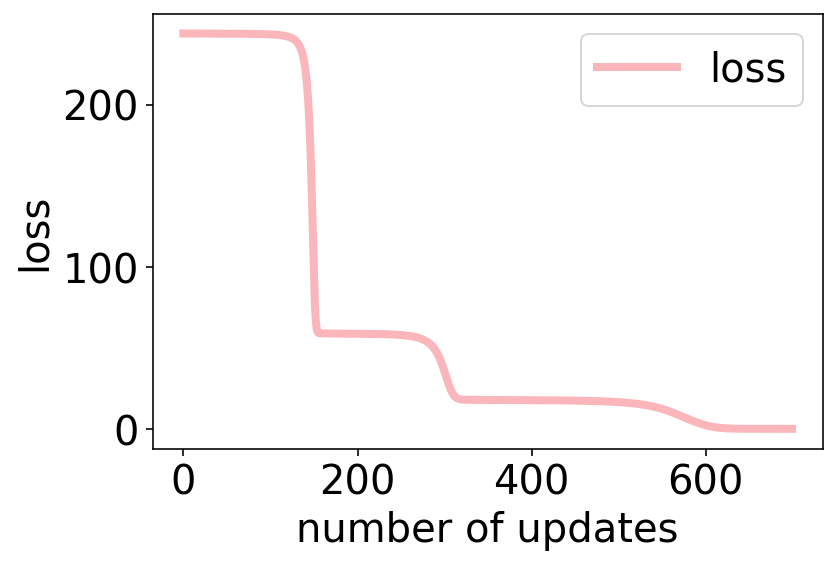

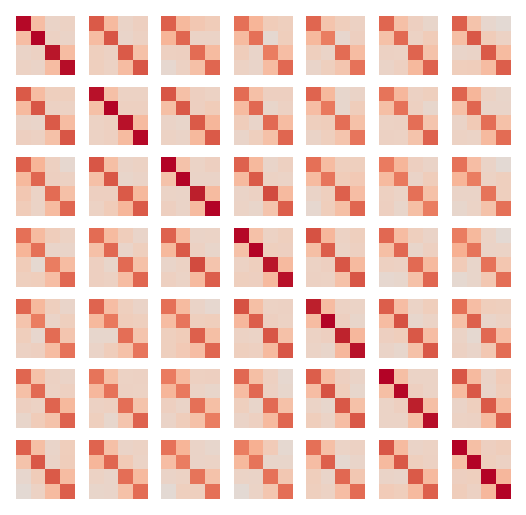

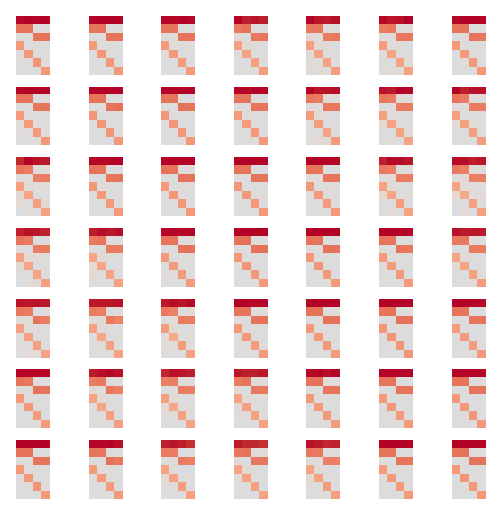

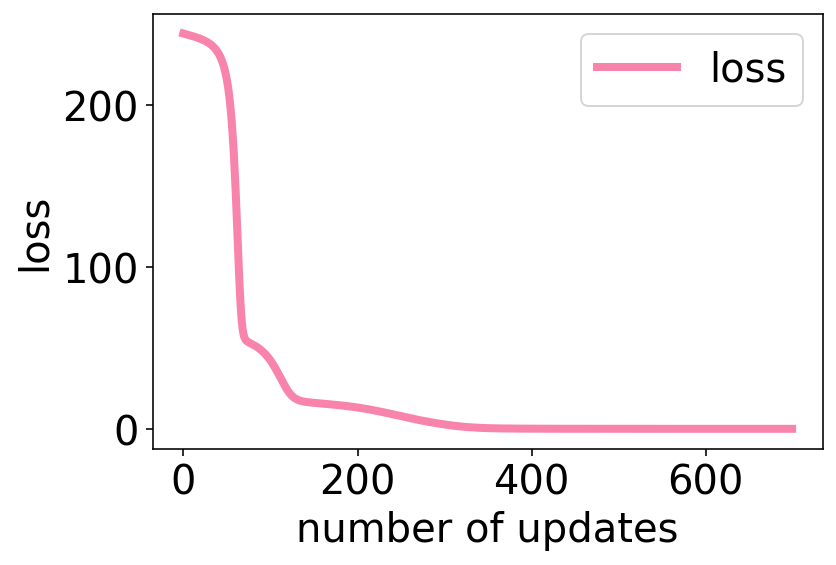

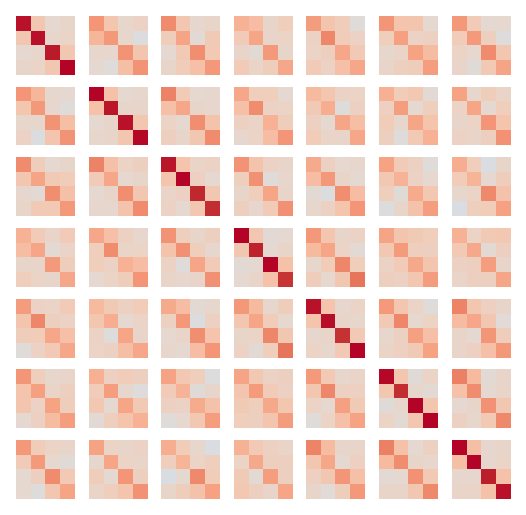

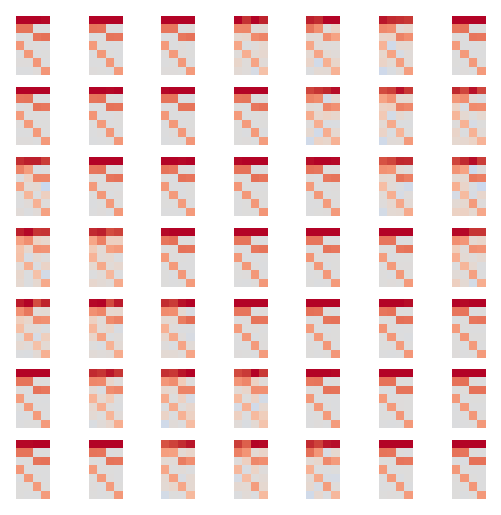

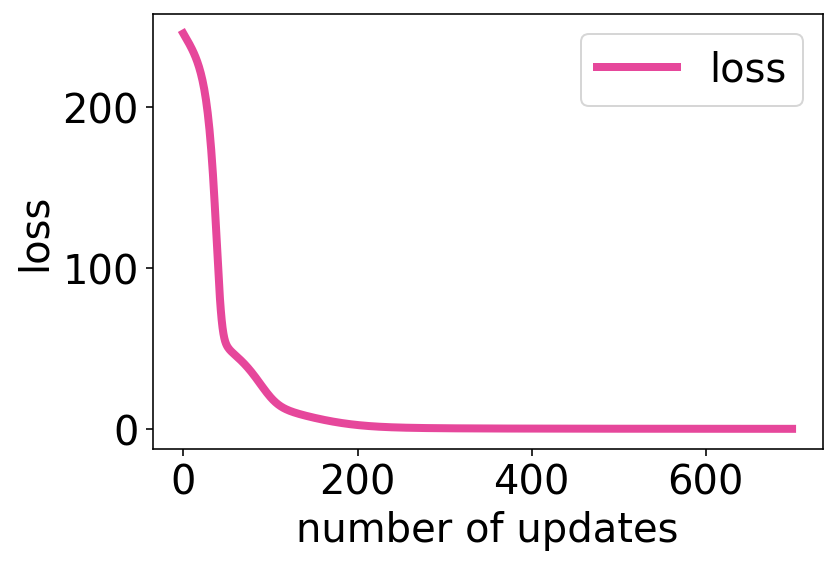

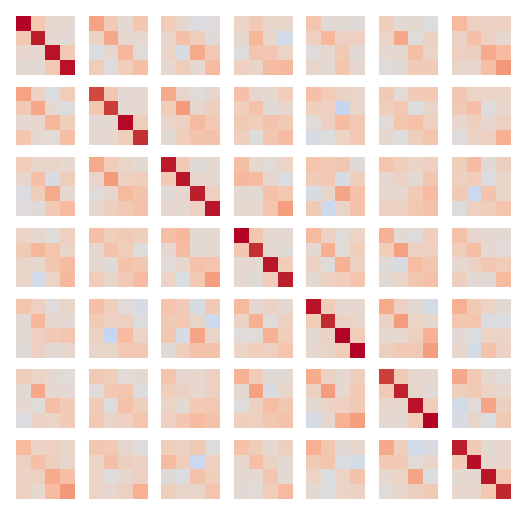

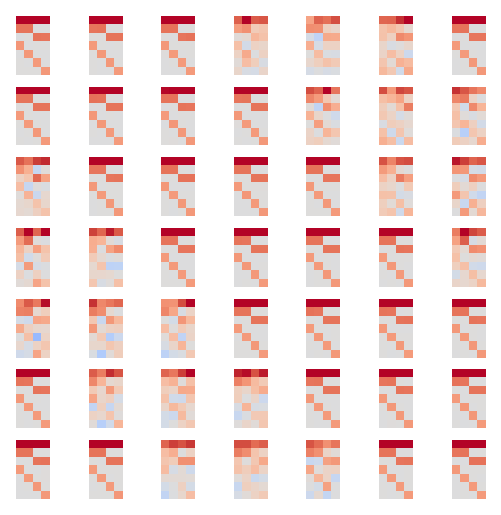

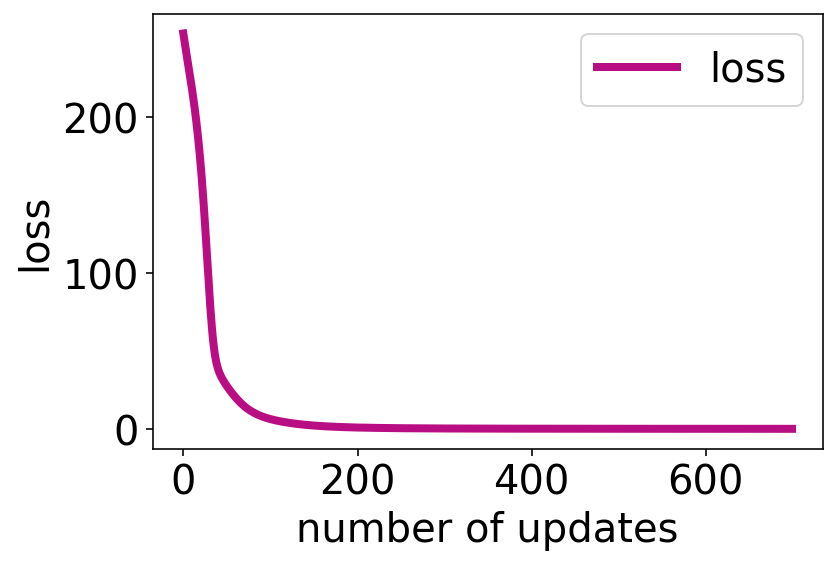

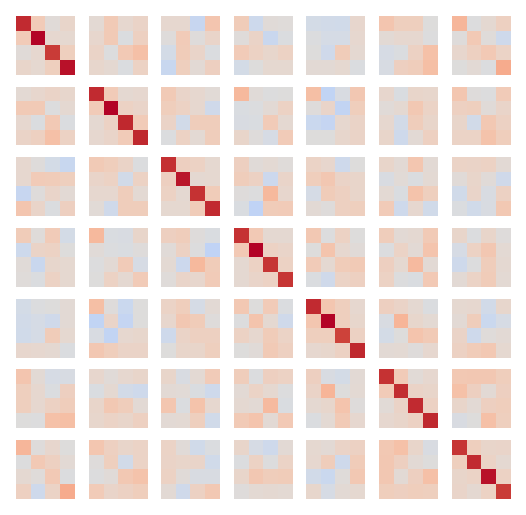

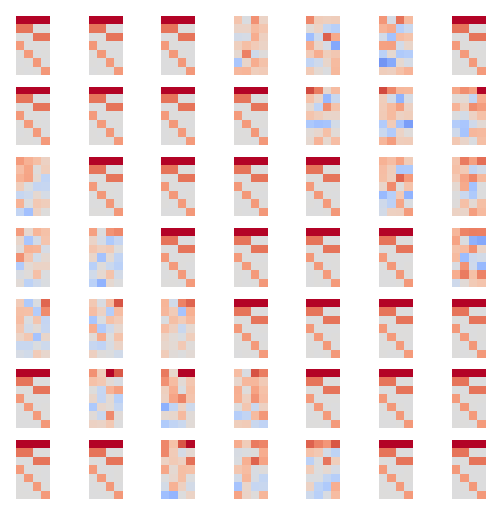

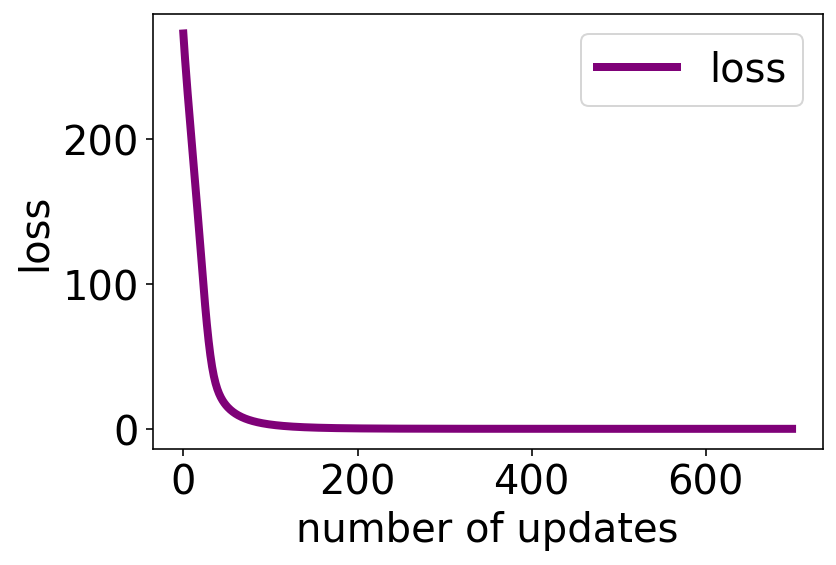

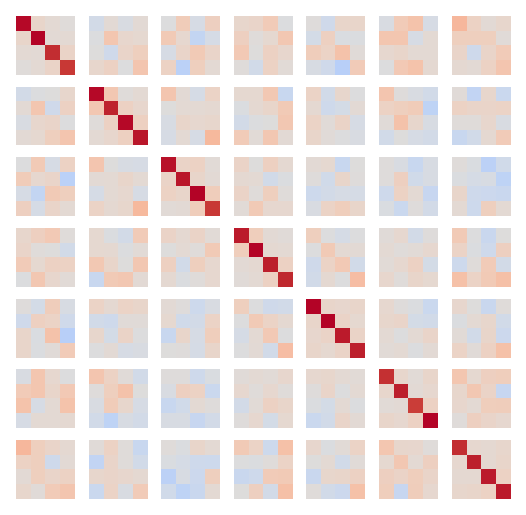

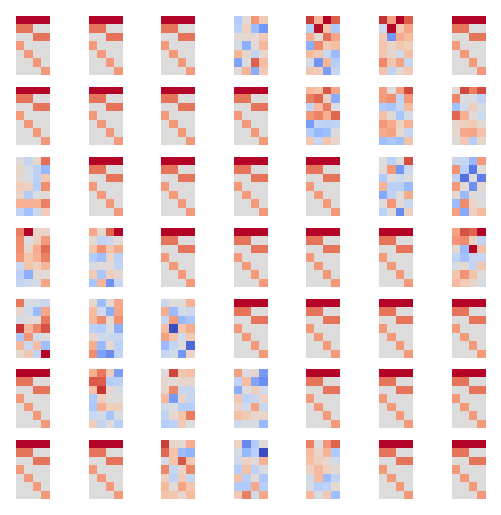

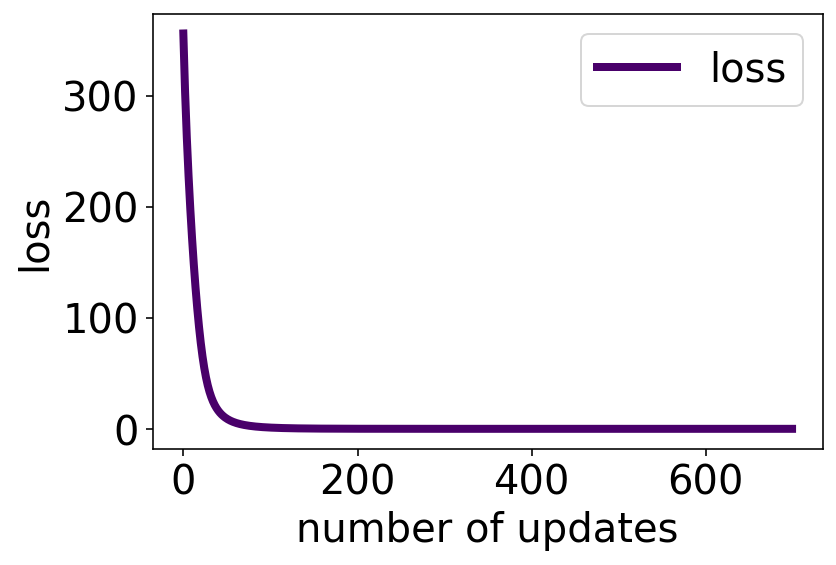

In [ ]:
cfg.num_epochs=700

Nsteps=6
init_scales = np.linspace(.2,2.5,Nsteps)#np.logspace(np.log10(.2),np.log10(2.5),Nsteps)
colors = plt.cm.RdPu(np.linspace(.3,1,Nsteps))

losses_ntk = []
input_svs_ntk = []
hidden_svs_ntk = []
out_svs_ntk = []

error_pattern = []

for i, init_scale in enumerate(init_scales):

    cfg.optimizer.lr = .006/float(init_scale**(1/3))
    cfg.init_scale = float(init_scale)

    Nreps_ntk = 1



    for rep in range(Nreps_ntk):
        model = GatedDLN(
            num_tasks=cfg.num_pathways,
            input_dim=cfg.input_dim,
            hidden_dims=cfg.hidden_dims,
            output_dim=cfg.output_dim,
            case=cfg.case,
            should_use_bias=cfg.should_use_bias,
        ).to(device)


        if not cfg.should_init_decoupled:
            model.apply(init_weights)

        else:
        # Fully balanced, ntkled init

            with torch.no_grad():

                u,s,v = np.linalg.svd(Y.T)
                Ninp = cfg.input_dim
                Nh = cfg.hidden_dims[0]
                Nout = cfg.output_dim
                r2,_,r1 = np.linalg.svd(model.hidden.weight)
                for m in model.input:
                    m.weight = torch.nn.Parameter(torch.tensor((r1.T)[:,0:Ninp] @ ( cfg.init_scale*np.eye(Ninp) ) @ v, dtype=torch.float))

                #r3,_,r4 = np.linalg.svd(np.random.normal(0,1,model.hidden.weight.shape))
                model.hidden.weight = torch.nn.Parameter(torch.tensor(r2 @ ( cfg.init_scale*np.eye(Nh) ) @ r1, dtype=torch.float))#torch.nn.Parameter(torch.tensor(r2 @ ( cfg.init_scale*np.eye(Nh) ) @ r1, dtype=torch.float))

                for m in model.out:
                    m.weight = torch.nn.Parameter(torch.tensor(u @ ( cfg.init_scale*np.eye(Nout) ) @ (r2.T)[0:Nout,:], dtype=torch.float))


        loss_fn = make_cls(cfg=deepcopy(cfg.loss))

        optimizer = make_cls(
            cfg=deepcopy(
                cfg.optimizer), kwargs={
                    "params": model.parameters()})

        loss_list = []

        input_sv_list = []
        hidden_sv_list = []
        out_sv_list = []


        for epoch in range(cfg.num_epochs):
            optimizer.zero_grad()
            loss = model(X, Y)
            loss_list.append(loss.detach().cpu())

            if False: #epoch%2==0:
                ui,si,vi = np.linalg.svd(model.input[0].weight.detach().numpy())
                input_sv_list.append(si)

                uh,sh,vh = np.linalg.svd(model.hidden.weight.detach().numpy())
                hidden_sv_list.append(sh[0:10])

                uo,so,vo = np.linalg.svd(model.out[0].weight.detach().numpy())
                out_sv_list.append(so[0:7])


            loss.backward()
            optimizer.step()
            
        plt.figure(figsize=(4, 4), dpi=80)

        # Figure out scale
        outA = model.input[0](X).detach().numpy()
        rsa = np.dot(outA, outA.T)
        c_limit = np.max(np.abs(rsa))

        for k in range(M):
            
            outA = model.input[k](X)
            #outA = model.hidden(outA)
            outA = outA.detach().numpy()

            for j in range(M):
                outB = model.input[j](X)
                #outB = model.hidden(outB)
                outB = outB.detach().numpy()

                plt.subplot(M, M, k*M+j+1)
                plt.imshow(np.dot(outA, outB.T), cmap=plt.cm.coolwarm)
                plt.clim(-c_limit,c_limit)
                plt.axis('off')

        plt.savefig(f"rsa_ntk_init_{init_scale:.2f}.pdf")
        plt.show()
        
    
        plt.figure(figsize=(4, 4), dpi=80)
        err_pat = np.zeros((M,M))
        for k in range(M):
            outA = model.input[k](X)
            h = model.hidden(outA)

            for j in range(M):
                o = model.out[j](h)

                plt.subplot(M, M, k*M+j+1)
                plt.imshow(o.detach().numpy().T,cmap=plt.cm.coolwarm)
                plt.clim((-6, 6))
                plt.axis('off')
                
                err_pat[j,k] = np.linalg.norm(Y-o.detach().numpy(),'fro')**2/2

        plt.savefig(f"routing_output_ntk_init_{init_scale:.2f}.pdf")
        plt.show()

        plt.figure()

        plt.plot(loss_list, color=colors[i], label="loss")
        plt.xlabel("number of updates")
        plt.ylabel("loss")
        plt.legend()

        losses_ntk.append(np.vstack(loss_list))
        error_pattern.append(err_pat)
        #input_svs_ntk.append(np.vstack(input_sv_list))
        #hidden_svs_ntk.append(np.vstack(hidden_sv_list))
        #out_svs_ntk.append(np.vstack(out_sv_list))
    
    

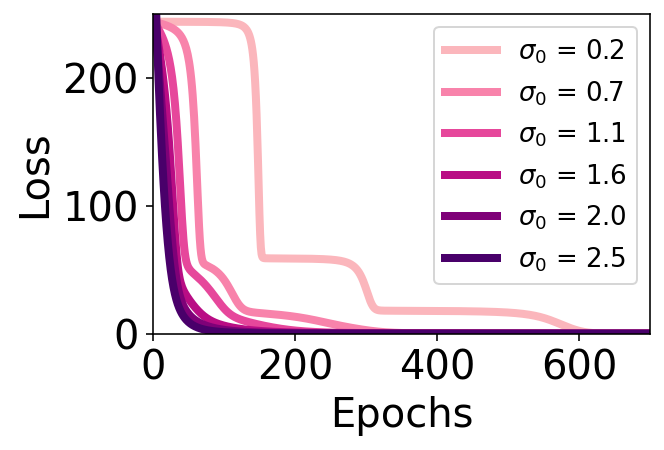

In [ ]:
plt.figure(figsize=(5,3.5))
for i, init_scale in enumerate(init_scales):
    plt.plot(losses_ntk[i], color=colors[i], label=f"$\sigma_0$ = {init_scale:.1f}")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")

plt.ylim((0,250))
plt.xlim((0,cfg.num_epochs))
plt.legend(fontsize=13)
plt.tight_layout()
plt.savefig('ntk_loss_dyn.pdf')

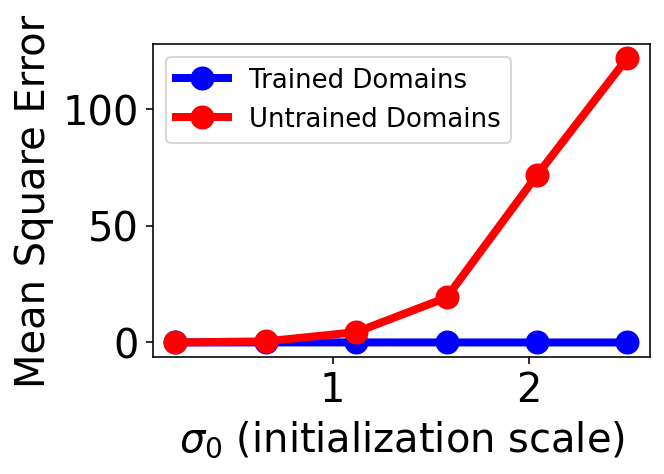

In [ ]:
train_err = [np.mean(ep.T[model.gate.detach().numpy().squeeze()>.5]) for ep in error_pattern]
test_err = [np.mean(ep.T[model.gate.detach().numpy().squeeze()<.5]) for ep in error_pattern]

plt.figure(figsize=(5,3.5))
plt.plot(init_scales,train_err,color='b', marker='o', markersize=10, label='Trained Domains')
plt.plot(init_scales,test_err, color='r', marker='o', markersize=10, label='Untrained Domains')
plt.legend(fontsize=13)
plt.xlabel('$\sigma_0$ (initialization scale)')
plt.ylabel('Mean Square Error')
plt.tight_layout()
plt.savefig('generalization_vs_init_scale.pdf')

In [ ]:
train_err

[0.07452754480417796,
 0.0020082223202686172,
 0.012503950706091485,
 0.03395384115179682,
 0.011760276870292222,
 3.775248230160689e-06]

array([6.40079126e-06, 3.97677993e-06, 8.34480955e+01, 2.82620511e-06,
       4.25103332e-06, 3.89680406e-06, 4.90401520e-06, 1.56602647e+02,
       9.18657673e-06, 1.05144317e-05, 3.39750541e-06, 7.44010341e+01,
       8.47821480e-06, 2.96584666e-06, 3.14229043e-06, 9.89999438e+01,
       2.06607567e-06, 6.06154091e-06, 2.31467844e-06, 1.08958971e+02,
       1.06572793e+02, 3.28532705e-06, 1.66476257e-06, 6.98654790e-07,
       2.33979959e-06, 1.06677925e+02, 1.57066166e-06, 2.65577107e-06])

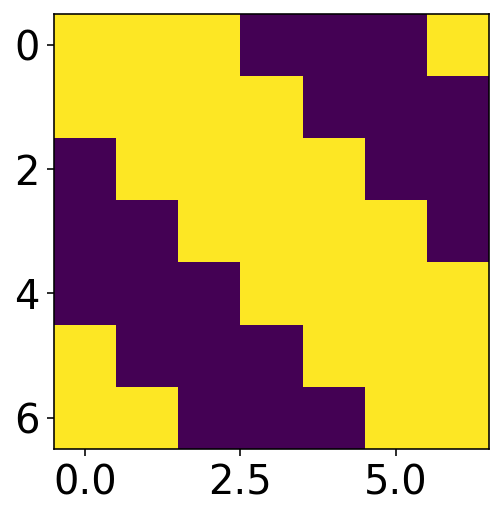

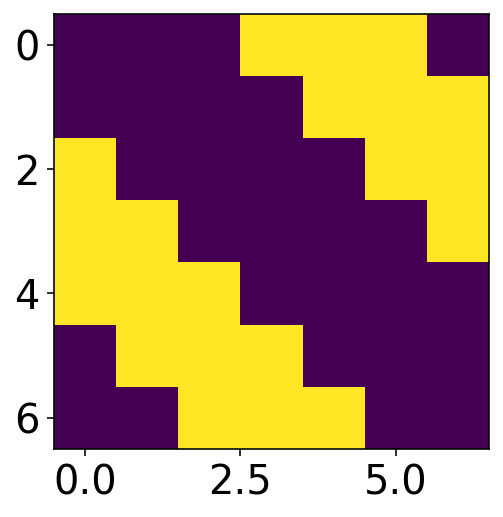

In [ ]:
plt.imshow(model.gate.detach().numpy().squeeze()>.5)
plt.show()
plt.imshow(error_pattern[-1].T)
plt.clim((0,20))